### Creating a Time Series Model on BTCUSD

* Linear Autoregression (AR) with multiple lags was explored. However there was no significant increase in adding further than 1 lag, as signals diminished.
* Next step will be to add volume as a feature.

* We will be using a linear model but using Pytorch for the weight and bias

In [18]:
from binance.client import Client
import pandas as pd
from datetime import datetime
import polars as pl
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import altair as alt
import matplotlib.pyplot as plt


from binance.client import Client
import pandas as pd
from datetime import datetime
import time

client = Client()

symbols = ["BTCUSDT", "XRPUSDT"]
interval = "4h"
start_date = "2020-01-01"
end_date = datetime.now().strftime("%d %b, %Y %H:%M:%S")

def get_data(symbol):
    cols = [
        "timestamp", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "num_trades",
        "taker_buy_base", "taker_buy_quote", "ignore"
    ]
    klines = client.get_historical_klines(symbol, interval, start_date, end_date)
    df = pd.DataFrame(klines, columns=cols)
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    df = df[["timestamp", "open", "high", "low", "close", "volume"]].astype(float, errors="ignore")
    df.set_index("timestamp", inplace=True)
    return df

# ✅ Loop through symbols and store in a dict
data = {}
for sym in symbols:
    print(f"Downloading {sym}...")
    data[sym] = get_data(sym)
    time.sleep(0.5)


# Combine both BTC and XRP close + volume into one DataFrame
prices = pd.concat(
    [
        data[sym][["close", "volume"]]
        .rename(columns={
            "close": f"{sym}_close",
            "volume": f"{sym}_volume"
        })
        for sym in symbols
    ],
    axis=1
)

print(prices.head())


                     BTCUSDT_close  BTCUSDT_volume  XRPUSDT_close  \
timestamp                                                           
2020-01-01 00:00:00        7225.01     2833.749180        0.19397   
2020-01-01 04:00:00        7209.83     2061.295051        0.19438   
2020-01-01 08:00:00        7197.20     3166.654361        0.19358   
2020-01-01 12:00:00        7234.19     3492.537459        0.19394   
2020-01-01 16:00:00        7229.48     2980.583291        0.19395   

                     XRPUSDT_volume  
timestamp                            
2020-01-01 00:00:00       6926988.2  
2020-01-01 04:00:00       4159719.0  
2020-01-01 08:00:00       5420125.1  
2020-01-01 12:00:00       4114708.1  
2020-01-01 16:00:00       3358625.4  


### Inspect data

In [19]:
prices.describe(include="all")
prices.value_counts()
prices.isna().mean()

BTCUSDT_close     0.0
BTCUSDT_volume    0.0
XRPUSDT_close     0.0
XRPUSDT_volume    0.0
dtype: float64

In [20]:
ts = prices
ts

,BTCUSDT_close,BTCUSDT_volume,XRPUSDT_close,XRPUSDT_volume
timestamp,,,,
2020-01-01 00:00:00,7225.01,2833.749180,0.19397,6926988.2
2020-01-01 04:00:00,7209.83,2061.295051,0.19438,4159719.0
2020-01-01 08:00:00,7197.20,3166.654361,0.19358,5420125.1
2020-01-01 12:00:00,7234.19,3492.537459,0.19394,4114708.1
2020-01-01 16:00:00,7229.48,2980.583291,0.19395,3358625.4
...,...,...,...,...
2025-11-06 20:00:00,101346.04,3664.898180,2.21300,27966635.3
2025-11-07 00:00:00,101916.29,3965.613720,2.22910,21760263.4
2025-11-07 04:00:00,102010.00,3062.610990,2.23350,13482578.9


ValueError: Using `title` of type `list` is not supported unless `subplots=True` is passed

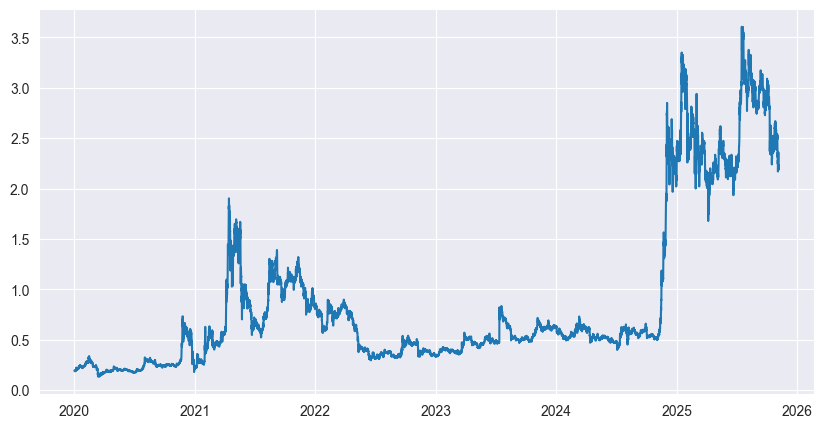

In [22]:
ts['XRPUSDT_close'].plot(figsize=(10,5),title=symbol)


### Feature Engineering


### Create target and lagged features using log returns

In [749]:
# Creating log return within ts dataframe.
ts = ts.sort_index()
ts['close_log_return']= np.log(ts['close']/ts['close'].shift(forcast_horizon))
ts['log_volume'] = np.log(ts['volume']/ts['volume'].shift(forcast_horizon))
ts

,open,high,low,close,volume,close_log_return,log_volume
timestamp,,,,,,,
2020-01-01 00:00:00,7195.24,7245.00,7175.46,7225.01,2833.749180,NaN,NaN
2020-01-01 04:00:00,7225.00,7236.27,7199.11,7209.83,2061.295051,-0.002103,-0.318266
2020-01-01 08:00:00,7209.83,7237.73,7180.00,7197.20,3166.654361,-0.001753,0.429341
2020-01-01 12:00:00,7197.20,7255.00,7196.15,7234.19,3492.537459,0.005126,0.097953
2020-01-01 16:00:00,7234.20,7249.99,7214.00,7229.48,2980.583291,-0.000651,-0.158510
...,...,...,...,...,...,...,...
2025-11-05 20:00:00,104008.09,104534.74,103305.05,103885.16,2687.898330,-0.001183,-0.714673
2025-11-06 00:00:00,103885.16,103933.33,102716.26,103636.03,3781.794370,-0.002401,0.341439
2025-11-06 04:00:00,103636.92,104200.00,102910.66,103185.48,2970.865520,-0.004357,-0.241345


In [826]:
# Create lagged features
target = 'close_log_return'
max_lags = 4
forcast_horizon = 1

# create 4 lagged features

ts = ts.copy() # this is to avoid setting with copy warning

ts[f'{target}_lag_1'] = ts[target].shift(forcast_horizon * 1)
ts[f'{target}_lag_2'] = ts[target].shift(forcast_horizon * 2)
ts[f'{target}_lag_3'] = ts[target].shift(forcast_horizon * 3)
ts[f'{target}_lag_4'] = ts[target].shift(forcast_horizon * 4)

ts['log_volume_lag_1'] = ts['log_volume'].shift(forcast_horizon * 1)
ts['log_volume_lag_2'] = ts['log_volume'].shift(forcast_horizon * 2)
ts['log_volume_lag_3'] = ts['log_volume'].shift(forcast_horizon * 3)



In [827]:
# better practice would be ts = ts.dropna()
ts.dropna(inplace=True)
ts

,open,high,low,close,volume,close_log_return,log_volume,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4,log_volume_lag_1,log_volume_lag_2,log_volume_lag_3
timestamp,,,,,,,,,,,,,,
2020-01-03 20:00:00,7343.62,7361.00,7260.01,7344.96,5894.343930,0.000256,-0.688590,0.003123,-0.002767,0.018875,0.035492,0.103713,-0.362221,-0.135225
2020-01-04 00:00:00,7345.00,7350.00,7280.85,7333.11,3693.784835,-0.001615,-0.467342,0.000256,0.003123,-0.002767,0.018875,-0.688590,0.103713,-0.362221
2020-01-04 04:00:00,7333.14,7369.28,7312.65,7348.11,4519.549891,0.002043,0.201761,-0.001615,0.000256,0.003123,-0.002767,-0.467342,-0.688590,0.103713
2020-01-04 08:00:00,7348.04,7369.63,7302.10,7336.45,5684.860065,-0.001588,0.229394,0.002043,-0.001615,0.000256,0.003123,0.201761,-0.467342,-0.688590
2020-01-04 12:00:00,7336.75,7339.58,7291.00,7318.99,4424.833286,-0.002383,-0.250574,-0.001588,0.002043,-0.001615,0.000256,0.229394,0.201761,-0.467342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-05 20:00:00,104008.09,104534.74,103305.05,103885.16,2687.898330,-0.001183,-0.714673,0.002694,0.016110,0.000760,-0.001342,-0.144379,0.573147,-0.264746
2025-11-06 00:00:00,103885.16,103933.33,102716.26,103636.03,3781.794370,-0.002401,0.341439,-0.001183,0.002694,0.016110,0.000760,-0.714673,-0.144379,0.573147
2025-11-06 04:00:00,103636.92,104200.00,102910.66,103185.48,2970.865520,-0.004357,-0.241345,-0.002401,-0.001183,0.002694,0.016110,0.341439,-0.714673,-0.144379


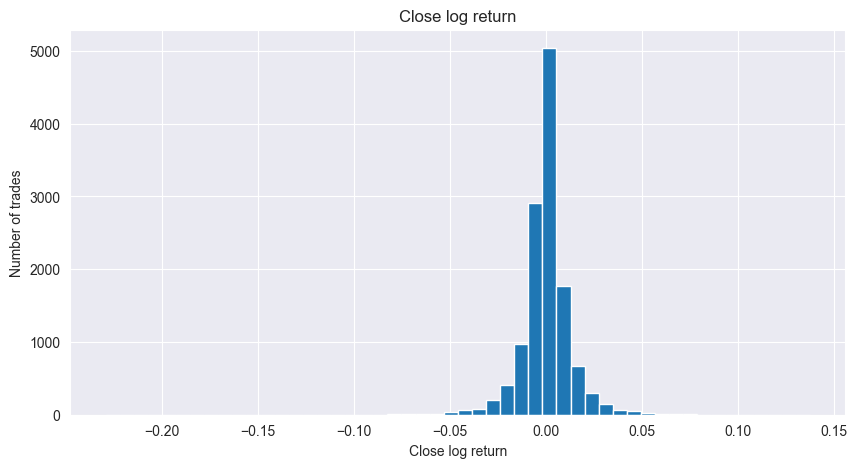

In [829]:
# Plot distribution

ts['close_log_return'].hist(bins=50, figsize=(10,5))
plt.title('Close log return')
plt.xlabel('Close log return')
plt.ylabel('Number of trades')

plt.show()


### Build Model

In [831]:
# we will use a linear model from torch.
# reason for linear model is the simplicity and interpretation
class LinearModel(nn.Module):
    def __init__(self, input_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_features, 1)

    def forward(self, x):
        return self.linear(x)

### Split by time
* Creating an AR1 model
* We are aiming to predict one return by its own lag
* splitting your data by scratch ensures no data leackage

In [865]:
 features = ['close_log_return_lag_1','log_volume_lag_1','log_volume_lag_2']
 target = 'close_log_return'
 test_size = 0.25 #

In [866]:
len(ts)

12802

In [867]:
len(ts)* test_size

3200.5

In [868]:
# to split the data by time, we will split it by the index.
# this will give us the train size below
split_idx = int(len(ts) *(1-test_size))
split_idx

9601

In [869]:
# split time series into 2 parts

ts_train,ts_test = ts[:split_idx], ts[split_idx:]

ts_train.head()

,open,high,low,close,volume,close_log_return,log_volume,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4,log_volume_lag_1,log_volume_lag_2,log_volume_lag_3
timestamp,,,,,,,,,,,,,,
2020-01-03 20:00:00,7343.62,7361.00,7260.01,7344.96,5894.343930,0.000256,-0.688590,0.003123,-0.002767,0.018875,0.035492,0.103713,-0.362221,-0.135225
2020-01-04 00:00:00,7345.00,7350.00,7280.85,7333.11,3693.784835,-0.001615,-0.467342,0.000256,0.003123,-0.002767,0.018875,-0.688590,0.103713,-0.362221
2020-01-04 04:00:00,7333.14,7369.28,7312.65,7348.11,4519.549891,0.002043,0.201761,-0.001615,0.000256,0.003123,-0.002767,-0.467342,-0.688590,0.103713
2020-01-04 08:00:00,7348.04,7369.63,7302.10,7336.45,5684.860065,-0.001588,0.229394,0.002043,-0.001615,0.000256,0.003123,0.201761,-0.467342,-0.688590
2020-01-04 12:00:00,7336.75,7339.58,7291.00,7318.99,4424.833286,-0.002383,-0.250574,-0.001588,0.002043,-0.001615,0.000256,0.229394,0.201761,-0.467342


In [870]:
ts_test.tail()

,open,high,low,close,volume,close_log_return,log_volume,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4,log_volume_lag_1,log_volume_lag_2,log_volume_lag_3
timestamp,,,,,,,,,,,,,,
2025-11-05 20:00:00,104008.09,104534.74,103305.05,103885.16,2687.89833,-0.001183,-0.714673,0.002694,0.016110,0.000760,-0.001342,-0.144379,0.573147,-0.264746
2025-11-06 00:00:00,103885.16,103933.33,102716.26,103636.03,3781.79437,-0.002401,0.341439,-0.001183,0.002694,0.016110,0.000760,-0.714673,-0.144379,0.573147
2025-11-06 04:00:00,103636.92,104200.00,102910.66,103185.48,2970.86552,-0.004357,-0.241345,-0.002401,-0.001183,0.002694,0.016110,0.341439,-0.714673,-0.144379
2025-11-06 08:00:00,103184.75,103440.00,102651.63,103227.58,2657.25315,0.000408,-0.111560,-0.004357,-0.002401,-0.001183,0.002694,-0.241345,0.341439,-0.714673
2025-11-06 12:00:00,103227.59,103626.46,102383.64,103065.66,2286.75136,-0.001570,-0.150161,0.000408,-0.004357,-0.002401,-0.001183,-0.111560,-0.241345,0.341439


In [871]:
# converting into torch tensors
# splitting our input and output into separate variables
X_train = torch.tensor(ts_train[features].to_numpy(), dtype=torch.float32)
X_test = torch.tensor(ts_test[features].to_numpy(), dtype=torch.float32)
Y_train = torch.tensor(ts_train[target].to_numpy(), dtype=torch.float32)
Y_test = torch.tensor(ts_test[target].to_numpy(), dtype=torch.float32)



In [872]:
X_train.shape # row vector


torch.Size([9601, 3])

In [873]:
Y_train.shape # one dimensional tensor

torch.Size([9601])

In [874]:
# We need to put it into a 2 dimensional

Y_train = Y_train.reshape(-1, 1)
Y_train.shape

torch.Size([9601, 1])

In [875]:
Y_test = Y_test.reshape(-1, 1)
Y_test.shape

torch.Size([3201, 1])

In [876]:
# Fit scaler on TRAIN only
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler().fit(ts_train[features].values)
X_train_np = x_scaler.transform(ts_train[features].values)
X_test_np  = x_scaler.transform(ts_test[features].values)

# Replace old torch tensor
X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test  = torch.tensor(X_test_np,  dtype=torch.float32)


### Batch Gradient Descent
* this trains all the data at once.

In [877]:
# specify hyperparameters which can be tweaked to improve model performance

no_epochs = 1000 * 5
lr = 0.0005

# Create Model
model = LinearModel(len(features))

#Loss Function L1Loss/MSE / L1Loss has been the strongest performer through testing
criterion = nn.L1Loss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

print('\nTraining...')
for epoch in range(no_epochs):
    # forward pass
    y_hat = model(X_train)
    loss = criterion(y_hat, Y_train)

    # Backward pass
    optimizer.zero_grad() # 1. clear old gradients
    loss.backward()       # 2. compute new gradients
    optimizer.step()      # 3. update weights

    # check for improvements by logging
    train_loss = loss.item()

    # logging
    if (epoch+1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{no_epochs}], Loss: {train_loss:.6f}')

    print('\nLearned parameters:')

    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}:\n {param.data.numpy()}')

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_hat = model(X_test)
        test_loss = criterion(y_hat, Y_test)
        print(f'\nTest loss: {test_loss.item():.6f}, Train loss: {train_loss:.6f}')





Training...

Learned parameters:
linear.weight:
 [[-0.50333863  0.25216696  0.44848427]]
linear.bias:
 [0.42991337]

Test loss: 0.614932, Train loss: 0.603173

Learned parameters:
linear.weight:
 [[-0.5028386   0.25166696  0.44798428]]
linear.bias:
 [0.42941338]

Test loss: 0.614199, Train loss: 0.602489

Learned parameters:
linear.weight:
 [[-0.5023386   0.25116718  0.44748425]]
linear.bias:
 [0.42891338]

Test loss: 0.613466, Train loss: 0.601806

Learned parameters:
linear.weight:
 [[-0.50183856  0.25066748  0.44698423]]
linear.bias:
 [0.4284134]

Test loss: 0.612733, Train loss: 0.601123

Learned parameters:
linear.weight:
 [[-0.5013385   0.25016797  0.4464842 ]]
linear.bias:
 [0.4279134]

Test loss: 0.612001, Train loss: 0.600440

Learned parameters:
linear.weight:
 [[-0.5008384   0.24966857  0.44598418]]
linear.bias:
 [0.42741343]

Test loss: 0.611268, Train loss: 0.599757

Learned parameters:
linear.weight:
 [[-0.5003383   0.24916925  0.44548413]]
linear.bias:
 [0.42691347]

Te

### Looking at the weight, which is negative, the model picked up a mean reversion adoption.

### Test Trading performance
* Create trade results from test data

In [878]:
trade_results = pl.DataFrame({
    'y_hat': y_hat.squeeze(),
    'y': Y_test.squeeze(),
}).with_columns(
    (pl.col('y_hat').sign()==pl.col('y').sign()).alias('is_won'),
    pl.col('y_hat').sign().alias('signal'),
).with_columns(
    (pl.col('signal') * pl.col('y')).alias('trade_log_return')
    ).with_columns(
        pl.col('trade_log_return').cum_sum().alias('equity_curve')
    )
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve
f32,f32,bool,f32,f32,f32
0.000342,-0.003447,false,1.0,-0.003447,-0.003447
0.000569,0.000303,true,1.0,0.000303,-0.003144
0.000252,0.010268,true,1.0,0.010268,0.007125
-0.000456,-0.011684,true,-1.0,0.011684,0.018809
0.001401,-0.006784,false,1.0,-0.006784,0.012024
…,…,…,…,…,…
0.000198,-0.001183,false,1.0,-0.001183,1.292134
0.000244,-0.002401,false,1.0,-0.002401,1.289733
0.00037,-0.004357,false,1.0,-0.004357,1.285376


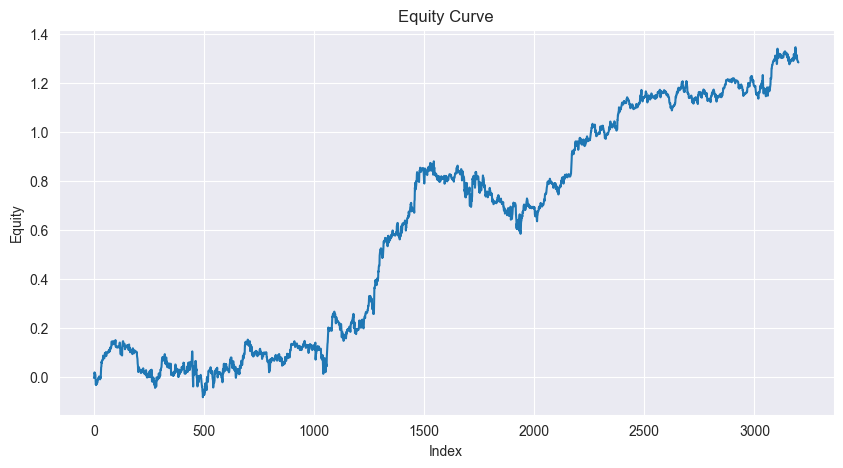

In [879]:
# plot equity curve
# Convert the Series to a NumPy array for plotting
y = trade_results['equity_curve'].to_numpy()

plt.figure(figsize=(10,5))
plt.plot(y)
plt.title("Equity Curve")
plt.xlabel("Index")
plt.ylabel("Equity")
plt.show()



In [880]:
# performance checking
trade_results = trade_results.with_columns(
    (pl.col('equity_curve')-pl.col('equity_curve').cum_max()).alias('drawdown_log')
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve,drawdown_log
f32,f32,bool,f32,f32,f32,f32
0.000342,-0.003447,false,1.0,-0.003447,-0.003447,0.0
0.000569,0.000303,true,1.0,0.000303,-0.003144,0.0
0.000252,0.010268,true,1.0,0.010268,0.007125,0.0
-0.000456,-0.011684,true,-1.0,0.011684,0.018809,0.0
0.001401,-0.006784,false,1.0,-0.006784,0.012024,-0.006784
…,…,…,…,…,…,…
0.000198,-0.001183,false,1.0,-0.001183,1.292134,-0.054065
0.000244,-0.002401,false,1.0,-0.002401,1.289733,-0.056466
0.00037,-0.004357,false,1.0,-0.004357,1.285376,-0.060823


In [881]:
# Max DD log

max_drawdown_log = trade_results['drawdown_log'].min()
max_drawdown_log

-0.295843243598938

In [882]:
# Putting into simple returns
drawdown_pct = np.exp(max_drawdown_log)-1
drawdown_pct

np.float64(-0.2560959694005872)

In [883]:
equity_peak = 1000
equity_peak * drawdown_pct

np.float64(-256.0959694005872)

In [884]:
# Win rate
win_rate = trade_results['is_won'].mean()
win_rate

0.5335832552327398

In [885]:
# Expected Value
avg_win = trade_results.filter(pl.col('is_won')==True)['trade_log_return'].mean()
avg_loss = trade_results.filter(pl.col('is_won')==False)['trade_log_return'].mean()
ev= win_rate * avg_win + (1-win_rate) * avg_loss
ev

0.000401191323099286

In [886]:
# total log return
total_log_return = trade_results['trade_log_return'].sum()
total_log_return

1.2842134237289429

In [887]:
compound_return = np.exp(total_log_return)
compound_return

np.float64(3.6118258630829874)

In [888]:
1000*compound_return

np.float64(3611.8258630829873)

In [889]:
# Equity trough

equity_trough = trade_results['equity_curve'].min()
equity_trough

-0.08244326710700989

In [890]:
# Equity peak

equity_peak = trade_results['equity_curve'].max()
equity_peak

1.3461991548538208

In [891]:
# std
std = trade_results['trade_log_return'].std()
std

0.009922855533659458

In [892]:
# Sharpe
annualized_rate = np.sqrt(365*24/4)
sharpe = ev / std * annualized_rate
sharpe


np.float64(1.8920687833737397)

In [784]:
# Highlighting itertools
import itertools
max_lags = 4
benchmarks = []
feature_pool = [f'{target}_lag_{i}' for i in range(1, max_lags + 1)]
combos = list(itertools.combinations(feature_pool, 1))

for features in combos:
    model = LinearModel(len(features))
    benchmarks.append()(ts,list(features),target, model, annualized_rate,no_epochs=200,loss=nn.L1Loss())

    benchmarks = pl.DataFrame(benchmarks)




TypeError: list.append() takes exactly one argument (0 given)

### Adding Transaction Fees

In [893]:
# 2 types of fees:
# 1: maker fee and taker fee

maker_fee = 0.0001
taker_fee = 0.0003

roundtrip_fee_log = np.log(1-2*maker_fee)

trade_results = trade_results.with_columns(pl.lit(roundtrip_fee_log).alias('tx_fee_log'))
trade_results = trade_results.with_columns((pl.col('trade_log_return')+pl.col('tx_fee_log')).alias('trade_log_return_net'))
trade_results = trade_results.with_columns(pl.col('trade_log_return_net').cum_sum().alias('equity_curve_net'))
trade_results

roundtrip_fee_log
trade_results


y_hat,y,is_won,signal,trade_log_return,equity_curve,drawdown_log,tx_fee_log,trade_log_return_net,equity_curve_net
f32,f32,bool,f32,f32,f32,f32,f64,f64,f64
0.000342,-0.003447,false,1.0,-0.003447,-0.003447,0.0,-0.0002,-0.003647,-0.003647
0.000569,0.000303,true,1.0,0.000303,-0.003144,0.0,-0.0002,0.000103,-0.003544
0.000252,0.010268,true,1.0,0.010268,0.007125,0.0,-0.0002,0.010068,0.006524
-0.000456,-0.011684,true,-1.0,0.011684,0.018809,0.0,-0.0002,0.011484,0.018009
0.001401,-0.006784,false,1.0,-0.006784,0.012024,-0.006784,-0.0002,-0.006984,0.011024
…,…,…,…,…,…,…,…,…,…
0.000198,-0.001183,false,1.0,-0.001183,1.292134,-0.054065,-0.0002,-0.001383,0.652669
0.000244,-0.002401,false,1.0,-0.002401,1.289733,-0.056466,-0.0002,-0.002601,0.650068
0.00037,-0.004357,false,1.0,-0.004357,1.285376,-0.060823,-0.0002,-0.004557,0.645511


### I tested multiple features, including varying lag and combinations thereof, but the highest yielding results remains in lag_1
### tweaks
* Increased time horizon from 1H to 4H and used the lag_1 feature.After scanning through all single features, lag_1 resulted in highest performance
* We can add further features next
* We can explore correlation next

### I have adjusted the lag to 1 and put the time_interval to 4h. This has increased the sharpe and net equity.

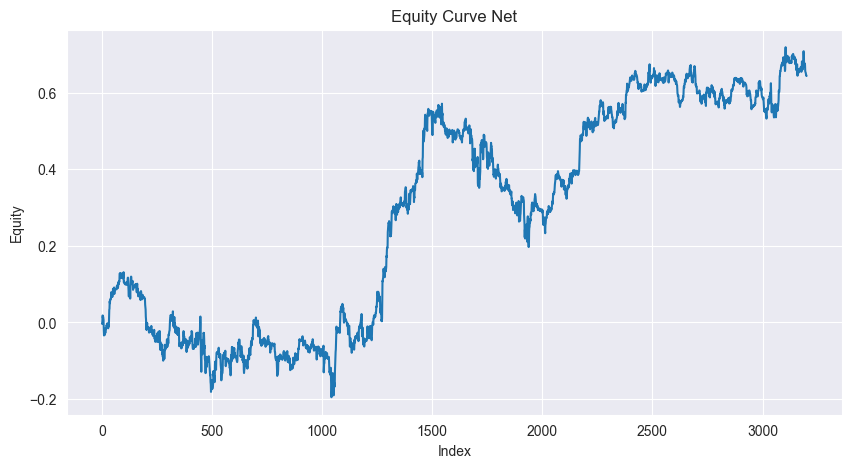

In [894]:
y = trade_results['equity_curve_net'].to_numpy()

plt.figure(figsize=(10,5))
plt.plot(y)
plt.title("Equity Curve Net")
plt.xlabel("Index")
plt.ylabel("Equity")
plt.show()

In [895]:
torch.save(model.state_dict(), 'model_weights.pth')

### Now to create my own research module to adjust models and their functions without changing the full model.
### This will assist in identifying strength of model between features.

In [ ]:
%%sql
# Save